# Imports

In [1]:
# HIDE 
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
sys.path.append('../../')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time

import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as t_optim
import pickle
from IPython import display
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import aif360 as aif

from fairness.helpers import *
from fairness.avd_helpers import *

import aif360
from aif360.datasets import CompasDataset
from aif360.algorithms.inprocessing import AdversarialDebiasing
import tensorflow.compat.v1 as tf
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import LFR

torch.manual_seed(1)
np.random.seed(7)
sns.set_theme()

tf.disable_eager_execution()

%matplotlib inline

# Load Data

In [4]:
df = pd.read_csv('../data/other/default of credit card clients.csv', sep=';', header=1)

In [5]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
X = pd.get_dummies(df.drop(columns=['SEX', 'default payment next month']))
y = df.rename({'default payment next month': 'default'}, axis=1).default
Z = (df.SEX==1).astype(int)

In [7]:
(X_train, X_test, y_train, y_test, Z_train, Z_test) = split_scale_pipe(X, y, Z, stratify=y)

### Train Biased Classifier

In [8]:
train_data = PandasDataSet(X_train, y_train, Z_train)
test_data = PandasDataSet(X_test, y_test, Z_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=False)


clf = Classifier_old(n_features=X_train.shape[1])
clf_criterion = nn.BCELoss()
clf_optimizer = optim.Adam(clf.parameters())

N_CLF_EPOCHS = 30

# pretrain classifier

biased_model, losses = fit_clf(clf, clf_optimizer, clf_criterion, train_loader, num_epochs=N_CLF_EPOCHS)

with torch.no_grad():
    pre_clf_test = biased_model(test_data.tensors[0])

y_pre_clf = pd.Series(pre_clf_test.data.numpy().ravel(),
                     index=y_test.index)

pre_clf_accuracy = metrics.accuracy_score(y_test, y_pre_clf > 0.5) * 100
b_acc = metrics.balanced_accuracy_score(y_test, y_pre_clf > 0.5) * 100
prule = p_rule(y_pre_clf, Z_test.values)

print(f'accuracy = {pre_clf_accuracy:.2f}%')
print(f'balanced accuracy = {b_acc:.2f}%')
print(f'p-rule = {prule:2f}%')

accuracy = 81.23%
balanced accuracy = 65.55%
p-rule = 85.346235%


In [9]:
#dataset_nodebiasing_test = biased_model(test_data)
test_results = pd.DataFrame(Z_test).assign(biased_pred = (pre_clf_test>0.5)*1).rename({'SEX':'sex'}, axis=1)
test_results.head()

,sex,biased_pred
9112,0,0
5514,0,0
10884,1,0
14055,0,0
4164,1,0


In [10]:
test_results.assign(n = 1).groupby(['sex', 'biased_pred']).count()

n
sex biased_pred      
0   0            7982
    1            1127
1   0            5037
    1             854

### LFR

In [11]:
from aif360.sklearn.preprocessing import LearnedFairRepresentations as LFRsk

pip install 'aif360[FairAdapt]'


In [14]:
lfr_accs = []
lfr_b_accs = []
lfr_prules = []
lfr_numch = []
lfr_changed = []

In [15]:
for i in range(10):

    lfrsk = LFRsk(prot_attr='sex', reconstruct_weight=0.01,
                     target_weight=1., fairness_weight=14, random_state=11).fit(X_train.assign(sex=Z_train).set_index('sex'), y_train)

    X_train_transf = lfrsk.transform(X_train.assign(sex=Z_train).set_index('sex')).set_index(X_train.index)
    X_test_transf = lfrsk.transform(X_test.assign(sex=Z_test).set_index('sex')).set_index(X_test.index)

    train_data = PandasDataSet(X_train_transf, y_train, Z_train)
    test_data = PandasDataSet(X_test_transf, y_test, Z_test)

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=False)

    start = time.time()

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=False)

    clf = Classifier_old(n_features=X_train.shape[1])
    clf_criterion = nn.BCELoss()
    clf_optimizer = optim.Adam(clf.parameters())

    N_CLF_EPOCHS = 30

    # pretrain classifier

    clf, losses = fit_clf(clf, clf_optimizer, clf_criterion, train_loader, num_epochs=N_CLF_EPOCHS)

    with torch.no_grad():
        pre_clf_test = clf(test_data.tensors[0])

    y_pre_clf = pd.Series(pre_clf_test.data.numpy().ravel(),
                         index=y_test.index)

    acc = metrics.accuracy_score(y_test, y_pre_clf > 0.5) * 100
    b_acc = metrics.balanced_accuracy_score(y_test, y_pre_clf > 0.5) * 100
    prule = p_rule(y_pre_clf, Z_test.values)

    print(f'run {i}')
    print(f'accuracy = {acc:.2f}%')
    print(f'balanced accuracy = {b_acc:.2f}%')
    print(f'p-rule = {prule:2f}%')

    lfr_accs.append(acc)
    lfr_b_accs.append(b_acc)
    lfr_prules.append(prule)

    t = test_results.assign(lfr_pred = (y_pre_clf>0.5)*1)
    t = t.assign(lfr_change = t.lfr_pred - t.biased_pred)
    changed = t[t.lfr_change!=0]

    num_changed = len(changed)
    lfr_changed.append(changed)
    lfr_numch.append(num_changed)
    print(num_changed)
    print()

run 0
accuracy = 80.25%
balanced accuracy = 63.14%
p-rule = 94.705056%
1170

run 1
accuracy = 80.40%
balanced accuracy = 62.19%
p-rule = 96.194965%
1183

run 2
accuracy = 80.35%
balanced accuracy = 62.04%
p-rule = 96.956880%
1176

run 3
accuracy = 80.35%
balanced accuracy = 61.45%
p-rule = 95.306550%
1196

run 4
accuracy = 80.42%
balanced accuracy = 62.32%
p-rule = 96.354690%
1178

run 5
accuracy = 80.25%
balanced accuracy = 62.64%
p-rule = 94.628736%
1188

run 6
accuracy = 80.37%
balanced accuracy = 61.76%
p-rule = 95.418151%
1191

run 7
accuracy = 80.39%
balanced accuracy = 60.95%
p-rule = 95.881138%
1192

run 8
accuracy = 80.35%
balanced accuracy = 62.12%
p-rule = 96.600426%
1174

run 9
accuracy = 80.37%
balanced accuracy = 62.46%
p-rule = 97.107039%
1166



In [16]:
lfr_stats = pd.DataFrame({
    'Run': range(1,11),
    'Accuracy':lfr_accs,
    'Balanced Accuracy': lfr_b_accs,
    'P%-rule': lfr_prules,
    '% of predictions changed': [l/len(X_test)*100 for l in lfr_numch],
    'lfr': [l/len(X_test)*100 for l in lfr_numch],
    'num of predictions changed': lfr_numch
})

lfr_stats

,Run,Accuracy,Balanced Accuracy,P%-rule,% of predictions changed,lfr,num of predictions changed
0,1,80.246667,63.139432,94.705056,7.800000,7.800000,1170
1,2,80.400000,62.191319,96.194965,7.886667,7.886667,1183
2,3,80.353333,62.042677,96.956880,7.840000,7.840000,1176
3,4,80.353333,61.449269,95.306550,7.973333,7.973333,1196
4,5,80.420000,62.322841,96.354690,7.853333,7.853333,1178
5,6,80.246667,62.643128,94.628736,7.920000,7.920000,1188
6,7,80.373333,61.764208,95.418151,7.940000,7.940000,1191
7,8,80.393333,60.946277,95.881138,7.946667,7.946667,1192
8,9,80.353333,62.118201,96.600426,7.826667,7.826667,1174
9,10,80.366667,62.461228,97.107039,7.773333,7.773333,1166


In [12]:
#dataset_nodebiasing_test = model.predict(test_tr)
test_results = test_results.assign(
    lfr_pred = (y_pre_clf>0.5).astype(int)
)

In [13]:
test_results = test_results.assign(lfr_change = test_results.lfr_pred - test_results.biased_pred)

In [14]:
metrics.balanced_accuracy_score(y_test, test_results.lfr_pred)
p_rule(y_pre_clf, Z_test.values)

95.12791105982781

### Adversarial Debiasing

In [17]:
from fairlearn_int.adversarial import AdversarialFairnessClassifier as AFC
from fairlearn_int.metrics import equalized_odds_difference, equalized_odds_ratio
import fairness.avd_helpers as avh


In [18]:
adv_accs = []
adv_b_accs = []
adv_prules = []
adv_numch = []
adv_changed = []

In [20]:
for i in range(10):
    torch.manual_seed(i*10000)
    
    afc = AFC(backend='torch',
       predictor_model=[32, nn.ReLU(), 32, nn.ReLU(), 32, nn.ReLU()],
       adversary_model=avh.Adversary_old(n_input=1, n_hidden=128),
              random_state=i*10000, shuffle=True,
       #constraints='equalized_odds',
       epochs=30,
       alpha=14).fit(X_train, y_train, sensitive_features=Z_train)

    preds = afc.predict(X_test)
    preds.index=X_test.index
    acc = metrics.accuracy_score(y_test, preds) * 100
    b_acc = metrics.balanced_accuracy_score(y_test, preds) * 100
    prule = p_rule(preds, Z_test.values)

    print(f'run {i}')
    print(f'accuracy = {acc:.2f}%')
    print(f'balanced accuracy = {b_acc:.2f}%')
    print(f'p-rule = {prule:.2f}%')

    adv_accs.append(acc)
    adv_b_accs.append(b_acc)
    adv_prules.append(prule)

    t = test_results.assign(pred = preds)
    t = t.assign(change = t.pred - t.biased_pred)
    changed = t[t.change!=0]

    num_changed = len(changed)
    adv_numch.append(num_changed)
    adv_changed.append(changed)

    print(num_changed)
    print()

run 0
accuracy = 81.40%
balanced accuracy = 66.23%
p-rule = 89.67%
779

run 1
accuracy = 81.23%
balanced accuracy = 66.38%
p-rule = 86.63%
689

run 2
accuracy = 81.33%
balanced accuracy = 66.20%
p-rule = 90.75%
687

run 3
accuracy = 81.25%
balanced accuracy = 65.95%
p-rule = 88.42%
759

run 4
accuracy = 81.21%
balanced accuracy = 65.77%
p-rule = 89.84%
781

run 5
accuracy = 81.51%
balanced accuracy = 66.00%
p-rule = 87.99%
731

run 6
accuracy = 81.40%
balanced accuracy = 65.01%
p-rule = 85.63%
781

run 7
accuracy = 79.86%
balanced accuracy = 61.67%
p-rule = 86.45%
1228

run 8
accuracy = 81.25%
balanced accuracy = 66.33%
p-rule = 92.74%
787

run 9
accuracy = 81.52%
balanced accuracy = 65.45%
p-rule = 89.95%
697



In [22]:
adv_stats = pd.DataFrame({
    'Run': range(len(adv_accs)),
    'Accuracy':adv_accs,
    'Balanced Accuracy': adv_b_accs,
    'P%-rule': adv_prules,
    'Number of instances changed': adv_numch,
    '% of predictions changed': [l/len(X_test)*100 for l in adv_numch],
    'adv': [l/len(X_test)*100 for l in adv_numch]
})

In [23]:
adv_stats

,Run,Accuracy,Balanced Accuracy,P%-rule,Number of instances changed,% of predictions changed,adv
0,0,81.366667,65.347401,87.399313,774,5.160000,5.160000
1,1,81.493333,65.428723,92.472236,779,5.193333,5.193333
2,2,81.493333,65.428723,92.472236,779,5.193333,5.193333
3,3,81.493333,65.428723,92.472236,779,5.193333,5.193333
4,4,81.400000,66.231940,89.672937,779,5.193333,5.193333
5,5,81.226667,66.379599,86.631134,689,4.593333,4.593333
6,6,81.333333,66.199928,90.751052,687,4.580000,4.580000
7,7,81.253333,65.954361,88.420330,759,5.060000,5.060000
8,8,81.213333,65.766842,89.839589,781,5.206667,5.206667
9,9,81.506667,65.998323,87.994224,731,4.873333,4.873333


In [17]:
print(f'accuracy = {metrics.accuracy_score(y_test, (preds>0.5) * 1) * 100:.2f}%')
print(f'balanced accuracy = {metrics.balanced_accuracy_score(y_test, (preds>0.5) * 1) * 100:.2f}%')
print(f'p-rule = {p_rule((preds>0.5) * 1, Z_test.values):.2f}%')

accuracy = 81.29%
balanced accuracy = 63.47%
p-rule = 98.09%


In [18]:
preds.index=test_results.index

In [19]:
test_results.head()

,sex,biased_pred,lfr_pred,lfr_change
9112,0,0,0,0
5514,0,0,0,0
10884,1,0,0,0
14055,0,0,0,0
4164,1,0,0,0


In [20]:
test_data = PandasDataSet(X_test, y_test, Z_test)

biased_preds = (biased_model(test_data.tensors[0]).detach()>0.5)*1

test_results = test_results.assign(adv_dp_pred = preds,
                                  adv_dp_change = preds - (biased_preds.detach().numpy().flatten()>0.5)*1)

### Adversarial Learning (Equalized Odds)

In [21]:
from fairlearn_int.adversarial import AdversarialFairnessClassifier as AFC
from fairlearn_int.metrics import equalized_odds_difference, equalized_odds_ratio

In [24]:
adv_eo_accs = []
adv_eo_b_accs = []
adv_eo_prules = []
adv_eo_eqd = []
adv_eo_eqr = []
adv_eo_numch = []
adv_eo_changed = []

In [30]:
for i in range(10):
    torch.manual_seed(i*10000)

    afc = AFC(backend='torch',
       predictor_model=[32, nn.ReLU(), 32, nn.ReLU(), 32, nn.ReLU()],
       adversary_model=avh.Adversary_old(n_input=2, n_hidden=128),
       random_state=i*10000, shuffle=True,
       constraints='equalized_odds',
       epochs=30,
       alpha=25).fit(X_train, y_train, sensitive_features=Z_train)

    preds = afc.predict(X_test)

    preds.index=X_test.index
    acc = metrics.accuracy_score(y_test, preds) * 100
    b_acc = metrics.balanced_accuracy_score(y_test, preds) * 100
    prule = p_rule(preds, Z_test.values)
    eq_odds_ratio = equalized_odds_ratio(y_true=y_test, y_pred=preds, 
                                                 sensitive_features=Z_test)
    eq_odds_diff = equalized_odds_difference(y_true=y_test, y_pred=preds, 
                                                 sensitive_features=Z_test)


    adv_eo_accs.append(acc)
    adv_eo_b_accs.append(b_acc)
    adv_eo_prules.append(prule)
    adv_eo_eqd.append(eq_odds_diff)
    adv_eo_eqr.append(eq_odds_ratio)

    t = test_results.assign(pred = preds)
    t = t.assign(change = t.pred - t.biased_pred)
    changed = t[t.change!=0]

    num_changed = len(changed)
    adv_eo_numch.append(num_changed)
    adv_eo_changed.append(changed)

    print(f'run {i}')
    print(f'accuracy = {acc:.2f}%')
    print(f'balanced accuracy = {b_acc:.2f}%')
    print(f'p-rule = {prule:.2f}%')
    print(f'Equalized Odds ratio = {eq_odds_ratio:.2f}')
    print(f'Equalized Odds difference = {eq_odds_diff:.2f}')
    print(f'Number of predictions changed = {num_changed}')
    print()

run 0
accuracy = 81.48%
balanced accuracy = 67.23%
p-rule = 84.20%
Equalized Odds ratio = 0.83
Equalized Odds difference = 0.02
Number of predictions changed = 783

run 1
accuracy = 81.33%
balanced accuracy = 66.75%
p-rule = 85.20%
Equalized Odds ratio = 0.84
Equalized Odds difference = 0.01
Number of predictions changed = 751

run 2
accuracy = 81.38%
balanced accuracy = 65.91%
p-rule = 85.90%
Equalized Odds ratio = 0.87
Equalized Odds difference = 0.01
Number of predictions changed = 730

run 3
accuracy = 80.80%
balanced accuracy = 67.70%
p-rule = 85.21%
Equalized Odds ratio = 0.88
Equalized Odds difference = 0.03
Number of predictions changed = 993

run 4
accuracy = 81.51%
balanced accuracy = 68.06%
p-rule = 85.72%
Equalized Odds ratio = 0.86
Equalized Odds difference = 0.02
Number of predictions changed = 851

run 5
accuracy = 81.40%
balanced accuracy = 66.23%
p-rule = 85.16%
Equalized Odds ratio = 0.86
Equalized Odds difference = 0.02
Number of predictions changed = 727

run 6
accu

In [31]:
adv_eo_stats = pd.DataFrame({
    'Run': range(1,11),
    'Accuracy':adv_eo_accs,
    'Balanced Accuracy': adv_eo_b_accs,
    'P%-rule': adv_eo_prules,
    'Number of instances changed': adv_eo_numch,
    '% of predictions changed': [l/len(X_test)*100 for l in adv_eo_numch],
    'adv_eo': [l/len(X_test)*100 for l in adv_eo_numch]
})

adv_eo_stats

,Run,Accuracy,Balanced Accuracy,P%-rule,Number of instances changed,% of predictions changed,adv_eo
0,1,81.480000,67.232753,84.201063,783,5.220000,5.220000
1,2,81.333333,66.750179,85.196632,751,5.006667,5.006667
2,3,81.380000,65.906212,85.904624,730,4.866667,4.866667
3,4,80.800000,67.702479,85.208911,993,6.620000,6.620000
4,5,81.506667,68.059066,85.722502,851,5.673333,5.673333
5,6,81.400000,66.231940,85.163975,727,4.846667,4.846667
6,7,81.053333,67.390396,86.484854,865,5.766667,5.766667
7,8,81.386667,67.420984,84.812918,837,5.580000,5.580000
8,9,81.420000,66.536089,90.438452,810,5.400000,5.400000
9,10,81.600000,66.532970,88.933718,725,4.833333,4.833333


In [23]:
test_data = PandasDataSet(X_test, y_test, Z_test)

biased_preds = (biased_model(test_data.tensors[0]).detach()>0.5)*1

In [24]:
biased_preds.flatten().numpy()

array([0, 0, 0, ..., 0, 0, 0])

In [25]:
print('Adversarial (optimizing equalized odds):')
print(f'accuracy = {metrics.accuracy_score(y_test, preds) * 100:.2f}%')
print(f'balanced accuracy = {metrics.balanced_accuracy_score(y_test, preds) * 100:.2f}%')
print(f'p-rule = {p_rule(preds, Z_test.values):.2f}%')

eq_odds_ratio = equalized_odds_ratio(y_true=y_test, y_pred=preds, 
                                                     sensitive_features=Z_test)
eq_odds_diff = equalized_odds_difference(y_true=y_test, y_pred=preds, 
                                                     sensitive_features=Z_test)

print(f'Equalized Odds ratio = {eq_odds_ratio:.2f}')
print(f'Equalized Odds difference = {eq_odds_diff:.2f}')

eq_odds_ratio = equalized_odds_ratio(y_true=y_test, y_pred=biased_preds, 
                                                     sensitive_features=Z_test)
eq_odds_diff = equalized_odds_difference(y_true=y_test, y_pred=biased_preds, 
                                                     sensitive_features=Z_test)

print()
print('Biased:')
print(f'accuracy = {metrics.accuracy_score(y_test, biased_preds) * 100:.2f}%')
print(f'balanced accuracy = {metrics.balanced_accuracy_score(y_test, biased_preds) * 100:.2f}%')
print(f'p-rule = {p_rule(biased_preds.flatten().numpy(), Z_test.values):.2f}%')
print(f'Equalized Odds ratio = {eq_odds_ratio:.2f}')
print(f'Equalized Odds difference = {eq_odds_diff:.2f}')


Adversarial (optimizing equalized odds):
accuracy = 81.23%
balanced accuracy = 64.14%
p-rule = 88.76%
Equalized Odds ratio = 0.96
Equalized Odds difference = 0.01

Biased:
accuracy = 81.23%
balanced accuracy = 65.55%
p-rule = 85.35%
Equalized Odds ratio = 0.86
Equalized Odds difference = 0.02


In [26]:
pp = pd.DataFrame(preds, columns=['pred']).set_index(test_results.index).pred

In [27]:
test_results = test_results.assign(adv_eq_pred = pp)
test_results = test_results.assign(adv_eq_change = test_results.adv_eq_pred - test_results.biased_pred)

In [28]:
test_results.head()

,sex,biased_pred,lfr_pred,lfr_change,adv_dp_pred,adv_dp_change,adv_eq_pred,adv_eq_change
9112,0,0,0,0,0,0,0,0
5514,0,0,0,0,0,0,0,0
10884,1,0,0,0,0,0,0,0
14055,0,0,0,0,0,0,0,0
4164,1,0,0,0,0,0,0,0


### Equal Odds

In [35]:
bld_train = BinaryLabelDataset(df=X_train.assign(y = y_train, sex = Z_train), label_names=['y'], protected_attribute_names=['sex'])
test_data = BinaryLabelDataset(df=X_test.assign(y = y_test, sex = Z_test), label_names=['y'], protected_attribute_names=['sex'])

In [36]:
from fairlearn_int.postprocessing import ThresholdOptimizer as TO

In [41]:
eo_accs = []
eo_b_accs = []
eo_prules = []
eo_rs = []
eo_ds = []
eo_numch = []
eo_changed = []

In [46]:
for i in range(10):
    
    m = TO(estimator=biased_model, predict_method='predict',
       prefit=True, constraints='equalized_odds',
      objective='accuracy_score').fit(X=X_train.assign(sex=Z_train).set_index('sex'), 
                                                             y=y_train,
                                                             Z=Z_train, 
                                                             sensitive_features=Z_train,
                                                                         bld=None)
    preds = m.predict(X=X_test, y=y_test, Z=Z_test, sensitive_features=Z_test,
                      bld=None)
    acc = metrics.accuracy_score(y_test, preds) * 100
    b_acc = metrics.balanced_accuracy_score(y_test, preds) * 100
    prule = p_rule(preds, Z_test)
    eq_odds_ratio = equalized_odds_ratio(y_true=y_test, y_pred=preds, 
                                                         sensitive_features=Z_test)
    eq_odds_diff = equalized_odds_difference(y_true=y_test, y_pred=preds, 
                                                         sensitive_features=Z_test)

    t = test_results.assign(pred = preds)
    t = t.assign(change = t.pred - t.biased_pred)
    changed = t[t.change!=0]

    num_changed = len(changed)
    eo_numch.append(num_changed)
    eo_changed.append(changed)
    eo_accs.append(acc)
    eo_b_accs.append(b_acc)
    eo_prules.append(prule)
    eo_rs.append(eq_odds_ratio)
    eo_ds.append(eq_odds_diff)

    print(f'run {i}:')
    print(f'accuracy = {acc:2f}%')
    print(f'balanced accuracy = {b_acc:.2f}%')
    print(f'p-rule = {prule:.2f}%')
    print(f'Equalized Odds ratio = {eq_odds_ratio:.2f}')
    print(f'Equalized Odds difference = {eq_odds_diff:.2f}')
    print(f'Number of instances changed: {num_changed}')
    print()

run 0:
accuracy = 80.933333%
balanced accuracy = 66.34%
p-rule = 95.23%
Equalized Odds ratio = 0.95
Equalized Odds difference = 0.02
Number of instances changed: 229

run 1:
accuracy = 80.893333%
balanced accuracy = 66.24%
p-rule = 94.83%
Equalized Odds ratio = 0.97
Equalized Odds difference = 0.01
Number of instances changed: 223

run 2:
accuracy = 80.926667%
balanced accuracy = 66.29%
p-rule = 96.35%
Equalized Odds ratio = 0.94
Equalized Odds difference = 0.01
Number of instances changed: 220

run 3:
accuracy = 80.900000%
balanced accuracy = 66.35%
p-rule = 96.03%
Equalized Odds ratio = 0.97
Equalized Odds difference = 0.01
Number of instances changed: 240

run 4:
accuracy = 80.906667%
balanced accuracy = 66.28%
p-rule = 94.59%
Equalized Odds ratio = 0.96
Equalized Odds difference = 0.01
Number of instances changed: 225

run 5:
accuracy = 80.913333%
balanced accuracy = 66.33%
p-rule = 96.35%
Equalized Odds ratio = 0.95
Equalized Odds difference = 0.01
Number of instances changed: 232

In [50]:
eo_stats = pd.DataFrame({
    'Run': range(len(eo_accs)),
    'Accuracy':eo_accs,
    'Balanced Accuracy': eo_b_accs,
    'P%-rule': eo_prules,
    'Equal Odds Ratio': eo_rs,
    'Equal Odds Difference': eo_ds,
    'Number of instances changed': eo_numch,
    '% of predictions changed': [l/len(X_test)*100 for l in eo_numch],
    'eo': [l/len(X_test)*100 for l in eo_numch]
}).loc[0:10]
eo_stats

,Run,Accuracy,Balanced Accuracy,P%-rule,Equal Odds Ratio,Equal Odds Difference,Number of instances changed,% of predictions changed,eo
0,0,80.866667,66.245577,95.234129,0.968615,0.012732,227,1.513333,1.513333
1,1,80.980000,66.469388,94.958219,0.974906,0.010260,246,1.640000,1.640000
2,2,80.853333,66.258595,95.848412,0.966106,0.013786,237,1.580000,1.580000
3,3,80.780000,66.179147,95.851007,0.963892,0.014668,248,1.653333,1.653333
4,4,80.933333,66.342324,95.234129,0.950561,0.020291,229,1.526667,1.526667
5,5,80.893333,66.241119,94.833376,0.968137,0.012910,223,1.486667,1.486667
6,6,80.926667,66.294887,96.350025,0.944244,0.008335,220,1.466667,1.466667
7,7,80.900000,66.353291,96.030764,0.967119,0.012023,240,1.600000,1.600000
8,8,80.906667,66.282047,94.587758,0.964375,0.014490,225,1.500000,1.500000
9,9,80.913333,66.329484,96.352991,0.952510,0.010442,232,1.546667,1.546667


In [40]:
preds = m.predict(X=X_test, y=y_test, Z=Z_test, sensitive_features=Z_test,
                  bld=None)
                 

In [33]:
metrics.accuracy_score(y_test, preds)

0.8091333333333334

In [34]:
metrics.balanced_accuracy_score(y_test, preds)

0.6635106234441142

In [35]:
p_rule(preds, Z_test.values)

94.67046672783007

In [36]:
eq_odds_ratio = equalized_odds_ratio(y_true=y_test, y_pred=preds, 
                                                     sensitive_features=Z_test)
eq_odds_diff = equalized_odds_difference(y_true=y_test, y_pred=preds, 
                                                     sensitive_features=Z_test)

print(eq_odds_ratio)
print(eq_odds_diff)

0.9807664166819098
0.007802876267086145


In [37]:
test_results = test_results.assign(eq_pred = preds)
test_results = test_results.assign(eq_change = test_results.eq_pred - test_results.biased_pred)

### Reject Option Classification

In [51]:
from fairness.avd_helpers import RejectOptionClassifier

In [54]:
scores = biased_model(torch.Tensor(X_test.to_numpy())).detach().numpy().flatten()
labels = (scores>0.5)*1

preds = RejectOptionClassifier(0.545).predict(scores, Z_test.values)

In [58]:
print(metrics.accuracy_score(y_test, labels)*100)
print(metrics.balanced_accuracy_score(y_test, labels)*100)
print(p_rule(scores, Z_test.values))

print('-------------')
print('debiased:')

print(metrics.accuracy_score(y_test, preds)*100)
print(metrics.balanced_accuracy_score(y_test, preds)*100)
print(p_rule(preds, Z_test.values))

acc = metrics.accuracy_score(y_test, preds)*100
b_acc = metrics.balanced_accuracy_score(y_test, preds)*100
prule = p_rule(preds, Z_test)

t = test_results.assign(pred = preds)
t = t.assign(change = t.pred - t.biased_pred)
num_changed = len(t[t.change!=0])
roc_stats = pd.DataFrame({
    'Run': range(1,11),
    'Accuracy':acc,
    'Balanced Accuracy': b_acc,
    'P%-rule': prule,
    'Number of instances changed': num_changed,
    '% of predictions changed': num_changed/len(X_test)*100,
    'roc': num_changed/len(X_test)*100
})

81.23333333333333
65.55310824244529
85.34623476331281
-------------
debiased:
81.42
65.09033232375863
98.51042835709413


In [59]:
roc_stats

,Run,Accuracy,Balanced Accuracy,P%-rule,Number of instances changed,% of predictions changed,roc
0,1,81.42,65.090332,98.510428,136,0.906667,0.906667
1,2,81.42,65.090332,98.510428,136,0.906667,0.906667
2,3,81.42,65.090332,98.510428,136,0.906667,0.906667
3,4,81.42,65.090332,98.510428,136,0.906667,0.906667
4,5,81.42,65.090332,98.510428,136,0.906667,0.906667
5,6,81.42,65.090332,98.510428,136,0.906667,0.906667
6,7,81.42,65.090332,98.510428,136,0.906667,0.906667
7,8,81.42,65.090332,98.510428,136,0.906667,0.906667
8,9,81.42,65.090332,98.510428,136,0.906667,0.906667
9,10,81.42,65.090332,98.510428,136,0.906667,0.906667


In [67]:
pd.concat([lfr_stats[['lfr']][0:10],
adv_stats[['adv']][0:10],
roc_stats[['roc']][0:10],
adv_eo_stats[['adv_eo']][0:10],
eo_stats[['eo']][0:10]], axis=1).to_csv('../results/runs/credit.csv')

In [42]:
test_results = test_results.assign(roc_pred=preds)

In [43]:
test_results = test_results.assign(roc_change = test_results.roc_pred - test_results.biased_pred)
test_results.head()

,sex,biased_pred,lfr_pred,lfr_change,adv_dp_pred,adv_dp_change,adv_eq_pred,adv_eq_change,eq_pred,eq_change,roc_pred,roc_change
9112,0,0,0,0,0,0,0,0,0,0,0.0,0.0
5514,0,0,0,0,0,0,0,0,0,0,0.0,0.0
10884,1,0,0,0,0,0,0,0,0,0,0.0,0.0
14055,0,0,0,0,0,0,0,0,0,0,0.0,0.0
4164,1,0,0,0,0,0,0,0,0,0,0.0,0.0


# Comparisons

In [44]:
test_results[test_results.isna().any(axis=1)]

,sex,biased_pred,lfr_pred,lfr_change,adv_dp_pred,adv_dp_change,adv_eq_pred,adv_eq_change,eq_pred,eq_change,roc_pred,roc_change


In [45]:
t = test_results.assign(
    target = y_test
)[[
    'sex', 'biased_pred', 'target',
    'lfr_pred', 'adv_dp_pred', 'roc_pred', 'adv_eq_pred', 'eq_pred',
    'lfr_change', 'adv_dp_change', 'roc_change', 'adv_eq_change', 'eq_change'
]].rename({'eqeq_pred':'eq_pred', 'eqeq_change':'eq_change'}, axis=1)

In [46]:
metrics_ = get_metrics([t[['sex', 'target', 'adv_dp_pred', 'biased_pred']].rename({'biased_pred':'biased_label', 'adv_dp_pred':'fair_label'}, axis=1),
                        t[['sex', 'target', 'roc_pred']].rename({'biased_pred':'biased_label', 'roc_pred':'fair_label'}, axis=1),
                        t[['sex', 'target', 'lfr_pred']].rename({'biased_pred':'biased_label', 'lfr_pred':'fair_label'}, axis=1),
                        t[['sex', 'target', 'adv_eq_pred']].rename({'biased_pred':'biased_label', 'adv_eq_pred':'fair_label'}, axis=1),
                        t[['sex', 'target', 'eq_pred']].rename({'biased_pred':'biased_label', 'eq_pred':'fair_label'}, axis=1),
                       ],
                       ['adversarial (dem parity)', 'ROC', 'LFR', 'adversarial (eq odds)', 'eq odds'],
                       sensitive_feature='sex'
                      )
metrics_.drop(columns=['class 0 accuracy', 'class 1 accuracy'])


,approach,accuracy,balanced accuracy,p% rules,eo_ratios,eo_diffs
0,adversarial (dem parity),0.812933,0.634662,98.091482,0.912603,0.028595
1,ROC,0.814200,0.650903,98.510428,0.857173,0.022685
2,LFR,0.802933,0.628997,95.127911,0.957220,0.013817
3,adversarial (eq odds),0.812267,0.641354,88.757159,0.959871,0.012960
4,eq odds,0.809133,0.663511,94.670467,0.980766,0.007803
5,biased,0.812333,0.655531,85.346235,0.858035,0.015343


In [47]:
#t = t.assign(
#    lfr_change = lambda x: x.lfr_pred-x.biased_pred,
#    adv_change = lambda x: x.adv_pred - x.biased_pred,
#    eq_change = lambda x: x.eq_pred - x.biased_pred
#        )
t.head()

,sex,biased_pred,target,lfr_pred,adv_dp_pred,roc_pred,adv_eq_pred,eq_pred,lfr_change,adv_dp_change,roc_change,adv_eq_change,eq_change
9112,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0
5514,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0
10884,1,0,0,0,0,0.0,0,0,0,0,0.0,0,0
14055,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0
4164,1,0,0,0,0,0.0,0,0,0,0,0.0,0,0


In [48]:
#t.to_csv('../results/credit/test_results.csv')

Text(0.5, 1.0, 'Methods Optimizing Equalized Odds')

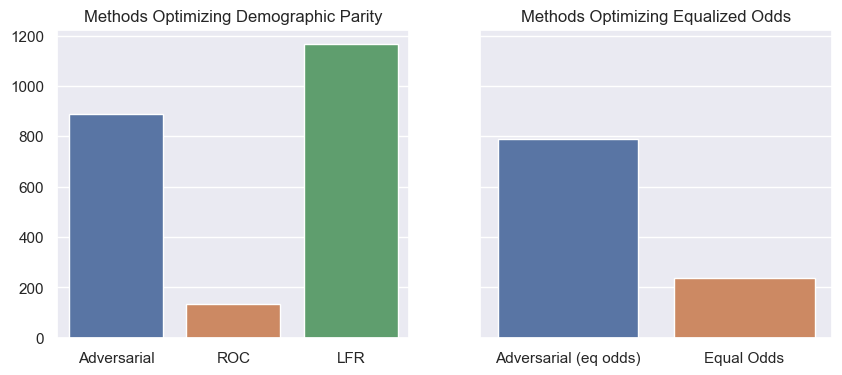

In [49]:
fig, axs = plt.subplots(1,2, figsize=(10,4), sharey=True)

sns.barplot(
    x=['Adversarial', 'ROC', 'LFR'],
    y=[len(t[t.adv_dp_change!=0]), len(t[t.roc_change!=0]),
      len(t[t.lfr_change!=0])],
    ax=axs[0]
           )
axs[0].set_title('Methods Optimizing Demographic Parity')

sns.barplot(
    x = ['Adversarial (eq odds)', 'Equal Odds'],
    y = [len(t[t.adv_eq_change!=0]), len(t[t.eq_change!=0])],
    ax=axs[1]
)
axs[1].set_title('Methods Optimizing Equalized Odds')

In [50]:
tt = t[(t.adv_dp_change!=0) | (t.roc_change!=0) | (t.lfr_change!=0)]
inters_dp = len(tt[(tt.adv_dp_change==tt.roc_change) & (tt.lfr_change==tt.roc_change) & (tt.lfr_change==tt.adv_dp_change)])
union_dp = len(tt)
iou_dp = inters_dp/union_dp * 100

print('Demographic parity methods:')
print(f'IOU(changed instances) = {iou_dp:.2f}%')

tt = t[(t.adv_eq_change!=0) | (t.eq_change!=0)]
inters_eo = len(tt[(tt.adv_eq_change==tt.eq_change)])
union_eo = len(tt)
iou_eo = inters_eo/union_eo * 100

print('Equalized Odds methods:')
print(f'IOU(changed instances) = {iou_eo:.2f}%')

tt = t[(t.adv_dp_change!=0) | (t.roc_change!=0) | (t.lfr_change!=0) | (t.adv_eq_change!=0) | (t.eq_change!=0)]
inters = len(tt[
    (tt.adv_dp_change==tt.roc_change) & (tt.lfr_change==tt.roc_change) & (tt.lfr_change==tt.adv_dp_change) &
    (tt.adv_eq_change==tt.eq_change) &
    (tt.adv_dp_change==tt.adv_eq_change) & (tt.lfr_change==tt.adv_eq_change) & (tt.roc_change==tt.adv_eq_change) &
    (tt.adv_dp_change==tt.eq_change) & (tt.lfr_change==tt.eq_change) & (tt.roc_change==tt.eq_change) 
])
union = len(tt)
iou = inters/union

print('All methods:')
print(f'IOU(changed instances) = {iou:.2f}%')

Demographic parity methods:
IOU(changed instances) = 3.88%
Equalized Odds methods:
IOU(changed instances) = 6.11%
All methods:
IOU(changed instances) = 0.00%


In [51]:
print('LFR:')
print(f'disadv group in positive class: {len(t[(t.sex==0) & (t.lfr_pred==1)]) / len(t[t.sex==0]) * 100:.2f}%')
print(f'priv group in positive class: {len(t[(t.sex==1) & (t.lfr_pred==1)]) / len(t[t.sex==1]) * 100:.2f}%')
print()

print('Adversarial (DP):')
print(f'disadv group in positive class: {len(t[(t.sex==0) & (t.adv_dp_pred==1)]) / len(t[t.sex==0]) * 100:.2f}%')
print(f'priv group in positive class: {len(t[(t.sex==1) & (t.adv_dp_pred==1)]) / len(t[t.sex==1]) * 100:.2f}%')
print()

print('ROC:')
print(f'disadv group in positive class: {len(t[(t.sex==0) & (t.roc_pred==1)]) / len(t[t.sex==0]) * 100:.2f}%')
print(f'priv group in positive class: {len(t[(t.sex==1) & (t.roc_pred==1)]) / len(t[t.sex==1]) * 100:.2f}%')
print()

print('Adversarial (EO):')
print(f'disadv group in positive class: {len(t[(t.sex==0) & (t.adv_eq_pred==1)]) / len(t[t.sex==0]) * 100:.2f}%')
print(f'priv group in positive class: {len(t[(t.sex==1) & (t.adv_eq_pred==1)]) / len(t[t.sex==1]) * 100:.2f}%')
print()

print('Equal Odds:')
print(f'disadv group in positive class: {len(t[(t.sex==0) & (t.eq_pred==1)]) / len(t[t.sex==0]) * 100:.2f}%')
print(f'priv group in positive class: {len(t[(t.sex==1) & (t.eq_pred==1)]) / len(t[t.sex==1]) * 100:.2f}%')
print()

print('Biased:')
print(f'disadv group in positive class: {len(t[(t.sex==0) & (t.biased_pred==1)]) / len(t[t.sex==0]) * 100:.2f}%')
print(f'priv group in positive class: {len(t[(t.sex==1) & (t.biased_pred==1)]) / len(t[t.sex==1]) * 100:.2f}%')
print()


LFR:
disadv group in positive class: 11.38%
priv group in positive class: 11.97%

Adversarial (DP):
disadv group in positive class: 10.44%
priv group in positive class: 10.64%

ROC:
disadv group in positive class: 12.37%
priv group in positive class: 12.19%

Adversarial (EO):
disadv group in positive class: 10.92%
priv group in positive class: 12.31%

Equal Odds:
disadv group in positive class: 14.45%
priv group in positive class: 15.26%

Biased:
disadv group in positive class: 12.37%
priv group in positive class: 14.50%



In [52]:
t_fts = df.loc[t.index].join(t)

adv_changed = t_fts[t_fts.adv_dp_change!=0]
eq_changed = t_fts[t_fts.eq_change!=0]
roc_changed = t_fts[t_fts.roc_change!=0]

adv_changed.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,lfr_pred,adv_dp_pred,roc_pred,adv_eq_pred,eq_pred,lfr_change,adv_dp_change,roc_change,adv_eq_change,eq_change
13151,13152,180000,2,2,1,34,1,2,2,2,...,1,0,1.0,1,1,0,-1,0.0,0,0
8886,8887,70000,1,3,0,26,1,2,2,0,...,1,1,0.0,1,0,1,1,0.0,1,0
9629,9630,50000,2,3,1,53,0,0,0,0,...,0,0,1.0,0,1,-1,-1,0.0,-1,0
1644,1645,50000,1,3,1,72,2,0,0,0,...,0,0,1.0,1,1,-1,-1,0.0,0,0
13106,13107,360000,2,1,1,49,1,-2,-2,-2,...,0,0,1.0,0,1,-1,-1,0.0,-1,0


In [53]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

# T-sne and PCA

In [55]:
t.head()

,sex,biased_pred,target,lfr_pred,adv_dp_pred,roc_pred,adv_eq_pred,eq_pred,lfr_change,adv_dp_change,roc_change,adv_eq_change,eq_change
9112,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0
5514,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0
10884,1,0,0,0,0,0.0,0,0,0,0,0.0,0,0
14055,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0
4164,1,0,0,0,0,0.0,0,0,0,0,0.0,0,0


In [57]:
ad_df = t[t.adv_dp_change!=0]
l_df = t[t.lfr_change!=0]
e_df = t[t.eq_change!=0]
r_df = t[t.roc_change!=0]
ae_df = t[t.adv_eq_change!=0]

In [59]:
from sklearn.manifold import TSNE

tsne_df = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=25).fit_transform(X_test.assign(z = Z_test))


In [60]:
import matplotlib.patches as mpatches

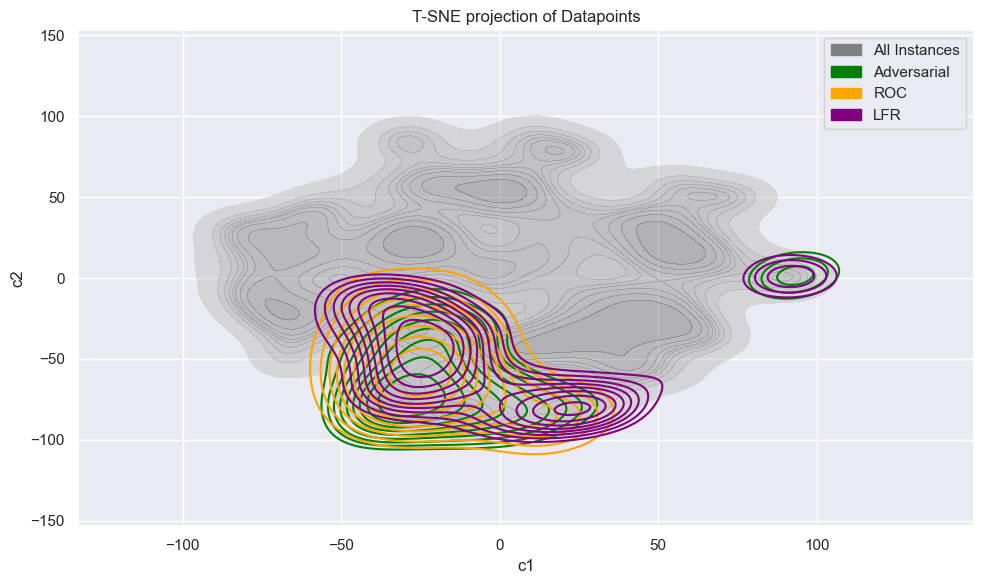

In [61]:
all_df = X_test.assign(z = Z_test).assign(c1 = tsne_df[:,0],
             c2 = tsne_df[:,1])

plot_ad = all_df.loc[ad_df.index]
plot_ae = all_df.loc[ae_df.index]
plot_r = all_df.loc[r_df.index]
plot_e = all_df.loc[e_df.index]
plot_l = all_df.loc[l_df.index]
plot_x = all_df#.loc[same_df.index]

fig, axs = plt.subplots(1,1, figsize=(10,6))#, sharex=True, sharey=True)

sns.kdeplot(data=plot_x, x='c1', y='c2', ax=axs, label='All Instances', fill=True, 
            thresh=0.05, alpha=0.4, legend=True, color='Grey', cut=0.5)

patch_all = mpatches.Patch(
    color='Grey', label='All Instances'
)

#sns.kdeplot(data=plot_e, x='c1', y='c2', ax=axs, label='Equal Odds', fill=False, thresh=0.4, color='Blue')#, cut=0.3)
#patch_eq = mpatches.Patch(
#    color='Blue', label='Equal Odds'
#)

sns.kdeplot(data=plot_ad, x='c1', y='c2', ax=axs, label='Adversarial', fill=False, thresh=0.4, color='Green')#, cut=0.3)
patch_adv = mpatches.Patch(
    color='Green', label='Adversarial'
)

sns.kdeplot(data=plot_r, x='c1', y='c2', ax=axs, label='ROC', fill=False, thresh=0.4, color='Orange')#, cut=0.3)
patch_roc = mpatches.Patch(
    color='Orange', label='ROC'
)

sns.kdeplot(data=plot_l, x='c1', y='c2', ax=axs, label='LFR', fill=False, thresh=0.4, color='Purple')
patch_lfr = mpatches.Patch(
    color='Purple', label='LFR'
)

label_patches = [patch_all, patch_adv, patch_roc, patch_lfr]


axs.legend(handles=label_patches)

axs.set_title('T-SNE projection of Datapoints')

#plt.xlim((-60,60))
#plt.ylim((-60,60))

#plt.savefig('../../figs/compas/tsne_all.pdf')
#plt.savefig('../../figs/compas/tsne_all.png')
plt.tight_layout()

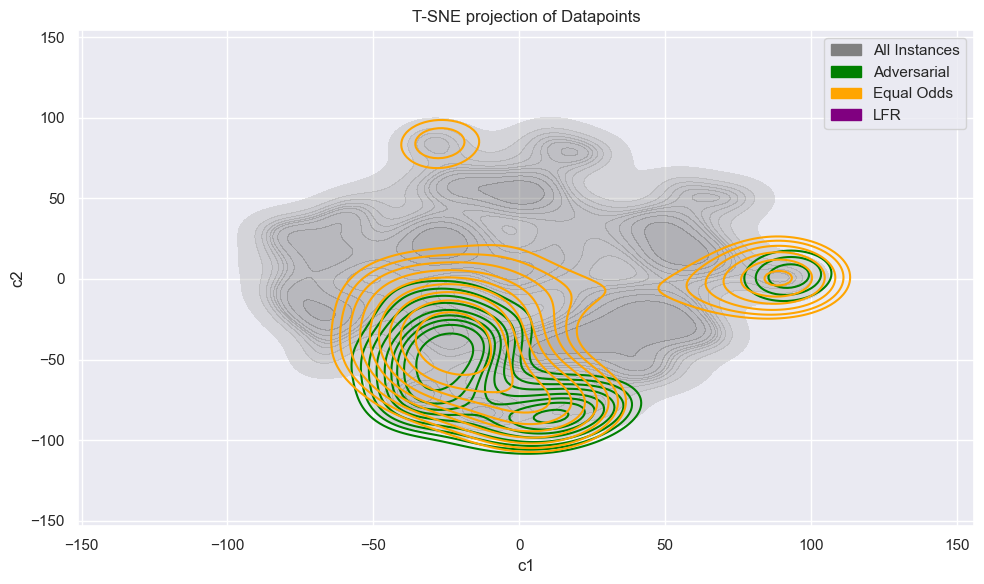

In [62]:
all_df = X_test.assign(z = Z_test).assign(c1 = tsne_df[:,0],
             c2 = tsne_df[:,1])

plot_ad = all_df.loc[ad_df.index]
plot_ae = all_df.loc[ae_df.index]
plot_r = all_df.loc[r_df.index]
plot_e = all_df.loc[e_df.index]
plot_l = all_df.loc[l_df.index]
plot_x = all_df#.loc[same_df.index]

fig, axs = plt.subplots(1,1, figsize=(10,6))#, sharex=True, sharey=True)

sns.kdeplot(data=plot_x, x='c1', y='c2', ax=axs, label='All Instances', fill=True, 
            thresh=0.05, alpha=0.4, legend=True, color='Grey', cut=0.5)

patch_all = mpatches.Patch(
    color='Grey', label='All Instances'
)

#sns.kdeplot(data=plot_e, x='c1', y='c2', ax=axs, label='Equal Odds', fill=False, thresh=0.4, color='Blue')#, cut=0.3)
#patch_eq = mpatches.Patch(
#    color='Blue', label='Equal Odds'
#)

sns.kdeplot(data=plot_ae, x='c1', y='c2', ax=axs, label='Adversarial', fill=False, thresh=0.4, color='Green')#, cut=0.3)
patch_adv = mpatches.Patch(
    color='Green', label='Adversarial'
)

sns.kdeplot(data=plot_e, x='c1', y='c2', ax=axs, label='Equal Odds', fill=False, thresh=0.4, color='Orange')#, cut=0.3)
patch_roc = mpatches.Patch(
    color='Orange', label='Equal Odds'
)

label_patches = [patch_all, patch_adv, patch_roc, patch_lfr]


axs.legend(handles=label_patches)

axs.set_title('T-SNE projection of Datapoints')

#plt.xlim((-60,60))
#plt.ylim((-60,60))

#plt.savefig('../../figs/compas/tsne_all.pdf')
#plt.savefig('../../figs/compas/tsne_all.png')
plt.tight_layout()

# Done till here (rest is old code /from other noteboks)

## Umap

In [ ]:
import umap
from umap import UMAP

In [ ]:
reducer = umap.UMAP()

In [ ]:
embedding = reducer.fit_transform(X_test)

In [ ]:
umap_df = pd.DataFrame(embedding, columns=['c1', 'c2'], index=X_test.index)
umap_df.head()

In [ ]:
sns.kdeplot(data=umap_df, x='c1', y='c2')#, kind='hex')

In [ ]:
all_df = umap_df#X_test.assign(c1 = umap_df[:,0],
             #c2 = umap_df[:,1])

plot_a = all_df.loc[a_df.index]
plot_l = all_df.loc[l_df.index]
plot_e = all_df.loc[e_df.index]
plot_x = all_df#.loc[same_df.index]

fig, axs = plt.subplots(1,1, figsize=(10,6))#, sharex=True, sharey=True)

sns.kdeplot(data=plot_x, x='c1', y='c2', ax=axs, label='All Instances', fill=True, 
            thresh=0.1, alpha=0.4, legend=True, color='Grey', cut=0.5)

patch_all = mpatches.Patch(
    color='Grey', label='All Instances'
)

sns.kdeplot(data=plot_e, x='c1', y='c2', ax=axs, label='Equal Odds', fill=False, thresh=0.6, color='Blue')#, cut=0.3)
patch_eq = mpatches.Patch(
    color='Blue', label='Equal Odds'
)

sns.kdeplot(data=plot_a, x='c1', y='c2', ax=axs, label='Adversarial', fill=False, thresh=0.6, color='Green')#, cut=0.3)
patch_adv = mpatches.Patch(
    color='Green', label='Adversarial'
)

sns.kdeplot(data=plot_l, x='c1', y='c2', ax=axs, label='LFR', fill=False, thresh=0.6, color='Orange')#, cut=0.3)
patch_lfr = mpatches.Patch(
    color='Orange', label='LFR'
)

label_patches = [patch_all, patch_eq, patch_adv, patch_lfr]


axs.legend(handles=label_patches)

axs.set_title('Umap projection of Datapoints')

plt.xlim((-30,40))
plt.ylim((-30,40))

plt.tight_layout()

In [ ]:
import umap

In [ ]:
reducer = umap.UMAP()

In [ ]:
embedding = reducer.fit_transform(changed)

In [ ]:
umap_df = pd.DataFrame(embedding, columns=['c1', 'c2'], index=changed.index)
umap_df.head()

In [ ]:
sns.kdeplot(data=umap_df, x='c1', y='c2')#, kind='hex')

In [ ]:
all_df = umap_df#X_test.assign(c1 = umap_df[:,0],
             #c2 = umap_df[:,1])

plot_a = all_df.loc[a_df.index]
plot_l = all_df.loc[l_df.index]
plot_e = all_df.loc[e_df.index]
plot_x = all_df#.loc[same_df.index]

fig, axs = plt.subplots(1,1, figsize=(10,6))#, sharex=True, sharey=True)

sns.kdeplot(data=plot_x, x='c1', y='c2', ax=axs, label='All Instances', fill=True, 
            thresh=0.1, alpha=0.4, legend=True, color='Grey', cut=0.5)

patch_all = mpatches.Patch(
    color='Grey', label='All Instances'
)

sns.kdeplot(data=plot_l, x='c1', y='c2', ax=axs, label='LFR', fill=False, thresh=0.6, color='Orange')#, cut=0.3)
patch_lfr = mpatches.Patch(
    color='Orange', label='LFR'
)

sns.kdeplot(data=plot_e, x='c1', y='c2', ax=axs, label='Equal Odds', fill=False, thresh=0.6, color='Blue')#, cut=0.3)
patch_eq = mpatches.Patch(
    color='Blue', label='Equal Odds'
)

sns.kdeplot(data=plot_a, x='c1', y='c2', ax=axs, label='Adversarial', fill=False, thresh=0.6, color='Green')#, cut=0.3)
patch_adv = mpatches.Patch(
    color='Green', label='Adversarial'
)

label_patches = [patch_all, patch_eq, patch_adv, patch_lfr]


axs.legend(handles=label_patches)

axs.set_title('Umap projection of Datapoints')

plt.xlim((-30,40))
plt.ylim((-20,35))

plt.tight_layout()

In [ ]:
import discrepancies as disc
from discrepancies import pool
from discrepancies import DIG

In [ ]:
class LFR_model:
    
    def __init__(self, lfr, model):
        self.lfr = lfr
        self.model = model
    
    def fit(self):
        pass
    
    def predict(self, XZ):
        bld = BinaryLabelDataset(df=XZ.assign(score_factor=0),
                                label_names=['score_factor'],
                                protected_attribute_names=['race'])
        return self.model.predict(self.lfr.transform(bld)).labels
    
class EQ_model:
    
    def __init__(self, model):
        self.model = model
    
    def fit(self):
        pass
    
    def predict(self, XZ):
        
        bld = BinaryLabelDataset(df=XZ.assign(score_factor=0),
                                label_names=['score_factor'],
                                protected_attribute_names=['race'])
        
        X = XZ.drop(columns = ['race'])
        y = pd.Series(np.zeros(len(X)), name='score_factor')
        Z = XZ['race']
        
        return self.model.predict(
            X=X, y=y, Z=Z, sensitive_features=Z,
            bld=bld
        )
    
class Adversarial_model:
    
    def __init__(self, model):
        self.model = model
        
    def fit(self):
        pass
    
    def predict(self, XZ):
        
        bld = BinaryLabelDataset(df=XZ.assign(score_factor=0),
                                label_names=['score_factor'],
                                protected_attribute_names=['race'])
        
        return self.model.predict(bld).labels

In [ ]:
lfr_wrap = LFR_model(lfr, model)
eq_wrap = EQ_model(m)
adv_wrap = Adversarial_model(debiased_model)
biased_wrap = Adversarial_model(biased_model)

#fpool = pool.FairnessPool([lfr_wrap, eq_wrap, adv_wrap, biased_wrap], 
#                          ['LFR', 'Equal Odds', 'Adversarial', 'Biased'],
#                         'race')

eq_pool = pool.FairnessPool([eq_wrap, biased_wrap], ['Equal Odds', 'Biased'], 'race')
adv_pool = pool.FairnessPool([adv_wrap, biased_wrap], ['Adversarial', 'Biased'], 'race')
lfr_pool = pool.FairnessPool([lfr_wrap, biased_wrap], ['LFR', 'Biased'], 'race')

In [ ]:
adv_pool.predict(XZ=X_test.join(y_test).join(Z_test))

In [ ]:
sample = X_test.join(Z_test).join(y_test).sample(100).assign(score_factor=0)
bld_sample = BinaryLabelDataset(
    df=sample,
    label_names=['score_factor'],
    protected_attribute_names=['race']
)

In [ ]:
sample.head()

In [ ]:
adv_pool.predict_discrepancies(sample)

In [ ]:
eq_digger = DIG.Digger(
    sample.drop(columns=['score_factor']),
    sample.score_factor,
    eq_pool,
    categorical_names=['sex', 'felony']
).fit(max_epochs=7)

In [ ]:
adv_digger = DIG.Digger(
    sample.drop(columns=['score_factor']),
    sample.score_factor,
    adv_pool,
    categorical_names=['sex', 'felony']
).fit(max_epochs=7)

In [ ]:
nodes = pd.concat([adv_digger.get_nodes_attributes(adv_digger.get_nodes())[0],
           adv_digger.get_nodes_attributes(adv_digger.get_nodes())[1]],
         axis=1).assign(discrepancy = lambda x: (x['Adversarial']!=x['Biased']).astype(int))

nodes.head()#[nodes.isna().any(axis=1)]

In [ ]:
(trainx, testx, trainy, testy,
     trainz, testz) = train_test_split(X, y, Z, test_size=0.5,
                                         stratify=y, random_state=11)

scaler = StandardScaler().fit(trainx)

nodes_unscaled = pd.DataFrame(scaler.inverse_transform(nodes[X_test.columns]), columns=X_test.columns,
            index=nodes.index)
nodes_unscaled.head()

In [ ]:
dff = pd.concat([
    nodes_unscaled,
    nodes[['race', 'Adversarial', 'Biased']]
], axis=1).assign(discrepancy = lambda x: (x['Adversarial']!=x['Biased']).astype(int))\
  .drop(columns=['Adversarial', 'Biased'])\
  .assign(race = lambda x: (x.race>0.5).astype(int))
dff.head()

In [ ]:
testx.describe()

In [ ]:
dff.describe()

In [ ]:
sc_dfff = nodes.assign(discrepancy = lambda x: (x['Adversarial']!=x['Biased']).astype(int)).drop(columns=['Adversarial', 'Biased', 'race'])

In [ ]:
#x_tree_train, x_tree_test, y_tree_train, y_tree_test = train_test_split(dff.drop(columns=['discrepancy']),
#                                                                       dff[['discrepancy']],
#                                                                       test_size=0.5, stratify=dff[['discrepancy']], random_state=11)

#x_tree_train, x_tree_test, y_tree_train, y_tree_test = train_test_split(sc_dfff.drop(columns=['discrepancy']),
#                                                                       sc_dfff[['discrepancy']],
#                                                                       test_size=0.5, stratify=sc_dfff[['discrepancy']], random_state=11)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=10)
clf = clf.fit(x_tree_train.to_numpy(), y_tree_train)

In [ ]:
preds = clf.predict(x_tree_test)

metrics.balanced_accuracy_score(y_tree_test, preds)

In [ ]:
from sklearn import tree

fig, axs = plt.subplots(1,1,figsize=(18,10))

tree.plot_tree(clf)

plt.show()

In [ ]:
list(X_test.columns)+['race']

In [ ]:
dff.race.unique()

In [ ]:
import graphviz

In [ ]:
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=list(X_test.columns), class_names=['not changed', 'changed'])
graph = graphviz.Source(dot_data)
#graph.render('adult'),

In [ ]:
graph.render('compas_adv')

In [ ]:
leaves = clf.apply(x_tree_test)

In [ ]:
tree_df = pd.DataFrame(scaler.inverse_transform(x_tree_test), columns=x_tree_test.columns, index=x_tree_test.index)\
            .assign(leaf=leaves).assign(discrepancy=y_tree_test)
tree_df.head()

In [ ]:
tree_df.groupby(['leaf', 'discrepancy']).count().reset_index().sort_values(['discrepancy', 'sex'], ascending=False)[0:10] #.sort_values('sex')

In [ ]:
x_tree_test.shape

In [ ]:
tree_df[tree_df.leaf==315].describe().drop(columns=['leaf', 'discrepancy']).loc[['min', 'max']].rename({'sex':'Gender',
                                                                                                       'age':'Age',
                                                                                                       'priors_count':'Priors',
                                                                                                       'juv_fel_count':'Juvenial Felonies',
                                                                                                       'juv_misd_count':'Juvenial Misdemeanors',
                                                                                                       'felony':'Felony'}, axis=1)

In [ ]:
tree_df[tree_df.leaf==263].describe().drop(columns=['leaf', 'discrepancy']).loc[['min', 'max']].rename({'sex':'Gender',
                                                                                                       'age':'Age',
                                                                                                       'priors_count':'Priors',
                                                                                                       'juv_fel_count':'Juvenial Felonies',
                                                                                                       'juv_misd_count':'Juvenial Misdemeanors',
                                                                                                       'felony':'Felony'}, axis=1)

In [ ]:
tree_df.head()

In [ ]:
t.groupby(['race', 'eq_change']).count()

In [ ]:
x_tree_train.head()

In [ ]:
nodes.assign()

In [ ]:
t.head()

In [ ]:
t.head()

In [ ]:
plot_df = dd.loc[t.index].assign(
    eq_change = t.eq_change,
    adv_change = t.adv_change,
    lfr_change = t.lfr_change
)

In [ ]:
plot_df[plot_df.eq_change!=0].describe()[['age', 'priors_count', 'juv_fel_count', 'juv_misd_count']]

In [ ]:
plot_df[plot_df.eq_change!=0].groupby('race').count()[['sex']].rename({'sex':'count'}).assign(method='Equal Odds').reset_index()

In [ ]:
plot_df[plot_df.lfr_change!=0].groupby('race').count()[['sex']].rename({'sex':'count'})

In [ ]:
plot_df[plot_df.adv_change!=0].groupby('race').count()[['sex']].rename({'sex':'count'})

In [ ]:
plot_df[plot_df.lfr_change!=0].describe()[['age', 'priors_count', 'juv_fel_count', 'juv_misd_count']]

In [ ]:
testx.head()

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
clusters = AgglomerativeClustering(n_clusters=10).fit_predict(nodes[nodes.discrepancy==1].drop(columns=['discrepancy', 'Adversarial', 'Biased']))

In [ ]:
agl_clusters = nodes[nodes.discrepancy==1].assign(cluster=clusters)
agl_clusters.head()

In [ ]:
from sklearn.cluster import AffinityPropagation

AffinityPropagation().fit_predict(trainx[trainx.discrepancy==1].drop(columns=['discrepancy', 'Adversarial', 'Biased']))

In [ ]:
from sklearn.manifold import TSNE

tsne_df = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=50).fit_transform(agl_clusters.drop(columns=['discrepancy', 'Adversarial', 'Biased', 'cluster']))


In [ ]:
all_df = agl_clusters.assign(c1 = tsne_df[:,0],
             c2 = tsne_df[:,1])

all_df.head()

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(14,7))

sns.scatterplot(data=all_df, x='c1', y='c2', hue='cluster', palette='colorblind')

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(14,7))

sns.scatterplot(data=all_df, x='c1', y='c2', palette='colorblind')

In [ ]:
all_df[all_df.cluster==1].describe()[['age', '']]

In [ ]:
len(all_df)

In [ ]:
sns.kdeplot(data=all_df, x='c1', y='c2', thresh = 0.6)

In [ ]:
all_df = changed.assign(c1 = tsne_df[:,0],
             c2 = tsne_df[:,1])

fig, axs = plt.subplots(1,1, figsize=(18,6))#, sharex=True, sharey=True)

sns.kdeplot(data=all_df, x='c1', y='c2', ax=axs, label='All Instances', fill=False, thresh=0.3)
sns.kdeplot(data=plot_e, x='c1', y='c2', ax=axs[1] , label='Equal Odds', fill=False, thresh=0.3)
sns.kdeplot(data=plot_a, x='c1', y='c2', ax=axs[1] , label='Adversarial', fill=False, alpha=0.6, thresh=0.3)
sns.kdeplot(data=plot_l, x='c1', y='c2', ax=axs[1] , label='LFR', fill=False, alpha=0.4, thresh=0.3)

plt.tight_layout()

# Decision Tree 2.0

In [ ]:
t.head()

In [ ]:
y_tree = (t.biased_pred!=t.adv_pred).astype(int)

In [ ]:
(X_train_og, X_test_og, _, _,
     _, _) = train_test_split(X, y, Z, test_size=0.5,
                                         stratify=y, random_state=11)

og_scaler = StandardScaler().fit(X_train_og)

In [ ]:
check = pd.concat([pd.DataFrame(og_scaler.inverse_transform(X_test), index=X_test.index, columns=X_test.columns), 
           X_test_og], axis=1)
check[check.sex!=check.sex_og]

In [ ]:
X_test_og.columns = X_test_og.columns.map(lambda x: x+'_og')

In [ ]:
tree_data = X_test.assign(race=Z_test)

scaler = StandardScaler().fit(tree_data)

scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), 
                                           columns=df.columns, index=df.index)
tree_data = tree_data.pipe(scale_df, scaler)

In [ ]:
tree_data.head()

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=6)
clf = clf.fit(tree_data.to_numpy(), y_tree)

In [ ]:
preds = clf.predict(tree_data)

metrics.balanced_accuracy_score(y_tree, preds)

In [ ]:
clusters = clf.apply(tree_data)

In [ ]:
cc = pd.DataFrame(og_scaler.inverse_transform(pd.DataFrame(scaler.inverse_transform(tree_data), 
                                         index=tree_data.index,
                                         columns=tree_data.columns).drop(columns=['race'])),
            index=tree_data.index,
            columns=X_test.columns)
cc = cc.assign(
    priors_count = round(cc.priors_count),
    juv_fel_count = round(cc.juv_fel_count)
)

In [ ]:
cc = cc.assign(segment=clusters, y=y_tree)
cc.head()

In [ ]:
cc.groupby('segment').count()[['age']].sort_values('age', ascending=False).head(5)

In [ ]:
cc[cc.y==1].groupby('segment').count()[['age']].sort_values('age', ascending=False).head(5)

In [ ]:
cc[cc.segment==51].describe()

In [ ]:
cc[cc.segment==22].describe()

# Random stuff

In [ ]:
df = pd.read_csv('../../results/compas/test_results.csv').rename({'Unnamed: 0': 'index'}, axis=1).set_index('index')\
                [['race', 'biased_pred', 'lfr_pred', 'adv_pred', 'eq_pred', 'target']]
df.head()

In [ ]:
comp = dd.loc[df.index].assign(
    biased_pred=df.biased_pred,
    adv_pred = df.adv_pred,
    lfr_pred = df.lfr_pred
)
comp.head()

In [ ]:
data = comp[comp.biased_pred != comp.adv_pred]
data_lfr = comp[comp.biased_pred != comp.lfr_pred]

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=
    go.Parcoords(
        line_color='blue',
        dimensions = list([
            dict(range = [data.age.min(), data.age.max()],
                 constraintrange = [1,2], # change this range by dragging the pink line
                 label = 'Age', values = data.age),
            
            dict(range = [0,1],
                 label = 'Race', values = data.race,
                 ticktext = ['Black', 'White']),
            
            dict(range = [0,1],
                 label = 'Sex', values = data.sex,
                 ticktext = ['Female', 'Male']),
            
            dict(range = [data.priors_count.min(), data.priors_count.max() ],
                 label = '# Priors', values = data.priors_count),
            
            dict(range = [data.juv_fel_count.min(), data.juv_fel_count.max()],
                 label='# juv. felonies', values = data.juv_fel_count
            ),
            dict(range = [data.biased_pred.min(), data.biased_pred.max()],
                 label='Biased Prediction', values = data.biased_pred
            )
        ])
    )
)
fig.show()

fig = go.Figure(data=
    go.Parcoords(
        line_color='blue',
        dimensions = list([
            dict(range = [data_lfr.age.min(), data_lfr.age.max()],
                 constraintrange = [1,2], # change this range by dragging the pink line
                 label = 'Age', values = data_lfr.age),
            
            dict(range = [0,1],
                 label = 'Race', values = data_lfr.race,
                 ticktext = ['Black', 'White']),
            
            dict(range = [0,1],
                 label = 'Sex', values = data_lfr.sex,
                 ticktext = ['Female', 'Male']),
            
            dict(range = [data_lfr.priors_count.min(), data_lfr.priors_count.max() ],
                 label = '# Priors', values = data_lfr.priors_count),
            
            dict(range = [0, 1],
                 label='# juv. felonies', values = data_lfr.juv_fel_count
            ),
            dict(range = [data_lfr.biased_pred.min(), data_lfr.biased_pred.max()],
                 label='Biased Prediction', values = data_lfr.biased_pred
            )
        ])
    )
)
fig.show()

In [ ]:
data_lfr.juv_fel_count.max()

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=
    go.Parcoords(
        line_color='blue',
        dimensions = list([
            dict(range = [data_lfr.age.min(), data_lfr.age.max()],
                 constraintrange = [1,2], # change this range by dragging the pink line
                 label = 'Age', values = data_lfr.age),
            
            dict(range = [0,1],
                 label = 'Race', values = data_lfr.race,
                 ticktext = ['Black', 'White']),
            
            dict(range = [0,1],
                 label = 'Sex', values = data_lfr.sex,
                 ticktext = ['Female', 'Male']),
            
            dict(range = [data_lfr.priors_count.min(), data_lfr.priors_count.max() ],
                 label = '# Priors', values = data_lfr.priors_count),
            
            dict(range = [data_lfr.juv_fel_count.min(), data_lfr.juv_fel_count.max()],
                 label='# juv. felonies', values = data_lfr.juv_fel_count
            ),
            dict(range = [data_lfr.biased_pred.min(), data_lfr.biased_pred.max()],
                 label='Biased Prediction', values = data_lfr.biased_pred
            )
        ])
    )
)
fig.show()

In [ ]:
data.shape

In [ ]:
data[data.sex==0]